# XGBOOST TPE

In [ ]:
# end_to_end_local_full_fixed.py

import os
import zipfile, json, gzip
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import joblib

# ————————————————————————
# 0) File paths – adjust if needed
# ————————————————————————
ZIP_PATH      = "CVES_2022-2023.zip"
NVD_2022_PATH = "nvdcve-1.1-2022.json.gz"
NVD_2023_PATH = "nvdcve-1.1-2023.json.gz"
EPSS_PATH     = "epss_scores-2023-12-31.csv.gz"
for p in (ZIP_PATH, NVD_2022_PATH, NVD_2023_PATH, EPSS_PATH):
    if not os.path.isfile(p):
        raise FileNotFoundError(f"Required file not found: {p}")

# ————————————————————————
# 1) Extract base CVE features from ZIP
# ————————————————————————
base_records = []
with zipfile.ZipFile(ZIP_PATH) as z:
    for fname in z.namelist():
        if not fname.endswith(".json"):
            continue
        rec = json.load(z.open(fname))
        meta = rec.get("cveMetadata", {})
        pub  = meta.get("datePublished", "")
        if not pub:
            continue
        year = int(pub[:4])
        if year not in (2022, 2023):
            continue
        cve_id = meta["cveId"]
        descs = rec["containers"]["cna"].get("descriptions", [])
        desc_len = len(descs[0]["value"]) if descs else 0
        refs = rec["containers"]["cna"].get("references", [])
        ref_count = len(refs)
        ptypes = rec["containers"]["cna"].get("problemTypes", [])
        cwe_count = sum(len(pt.get("descriptions", [])) for pt in ptypes)
        parts = cve_id.split("-")
        id_year, id_num = int(parts[1]), int(parts[2])
        base_records.append({
            "cve":         cve_id,
            "year":        id_year,
            "id_number":   id_num,
            "desc_length": desc_len,
            "ref_count":   ref_count,
            "cwe_count":   cwe_count
        })
features_df = pd.DataFrame(base_records)
print(f"1) Base features: {len(features_df)} CVEs")

# ————————————————————————
# 2) Load NVD feeds for CVSS v3 (correctly pulling exploit & impact)
# ————————————————————————
def load_nvd_feed(path):
    with gzip.open(path, "rt", encoding="utf-8") as f:
        data = json.load(f)
    items = data.get("CVE_Items", [])
    print(f"   -> {path}: {len(items)} items")
    recs = []
    for it in items:
        cid = it["cve"]["CVE_data_meta"]["ID"]
        bm3 = it.get("impact", {}).get("baseMetricV3", {})
        cv3 = bm3.get("cvssV3", {})
        recs.append({
            "cve":           cid,
            "cvss_base":     bm3.get("cvssV3", {}).get("baseScore",      np.nan),
            "cvss_exploit":  bm3.get("exploitabilityScore",            np.nan),
            "cvss_impact":   bm3.get("impactScore",                    np.nan)
        })
    df = pd.DataFrame(recs)
    # drop CVEs without any v3 data
    df = df.dropna(subset=["cvss_base","cvss_exploit","cvss_impact"])
    print(f"   -> After dropna: {len(df)} CVEs with full v3 metrics")
    return df

cvss22 = load_nvd_feed(NVD_2022_PATH)
cvss23 = load_nvd_feed(NVD_2023_PATH)
cvss_df = pd.concat([cvss22, cvss23], ignore_index=True)
print(f"2) Combined CVSS v3: {len(cvss_df)} records")

# ————————————————————————
# 3) Merge base + CVSS and sample 10k per year
# ————————————————————————
df = features_df.merge(cvss_df, on="cve", how="inner")
print(f"3) After merge: {len(df)} CVEs")
if df.empty:
    raise RuntimeError("Merge produced zero rows—check your inputs")

S=42
df22 = df[df["year"]==2022].sample(n=10000, random_state=S)
df23 = df[df["year"]==2023].sample(n=10000, random_state=S)
features_df = pd.concat([df22, df23], ignore_index=True)
print(f"3) Sampled: {len(features_df)} CVEs ({len(df22)}/2022, {len(df23)}/2023)")

# ------------------
# 4) Load EPSS snapshot and merge target (fixed column names)
# ------------------
EPSS_PATH = "epss_scores-2023-12-31.csv.gz"  # or .csv

# Read, skipping the first two metadata rows, with no header
epss_full = pd.read_csv(
    EPSS_PATH,
    compression = "gzip" if EPSS_PATH.endswith(".gz") else None,
    skiprows    = 2,
    header      = None,
    names       = ["cve", "epss", "percentile"]
)

print("EPSS columns:", epss_full.columns.tolist())
# → ['cve','epss','percentile']

# Filter to your sampled CVEs
epss_sub = epss_full[epss_full["cve"].isin(features_df["cve"])]
print(f"   → EPSS total rows:            {len(epss_full)}")
print(f"   → EPSS matching sampled CVEs: {len(epss_sub)}")

# Merge the target
df = features_df.merge(epss_sub[["cve","epss"]], on="cve", how="inner")
print(f"4) Final dataset rows: {len(df)}")
if df.empty:
    raise RuntimeError("No EPSS rows merged—check EPSS_PATH and sample CVEs.")



# ————————————————————————
# 5) Split & scale
# ————————————————————————
feature_cols = [
    "year","id_number","desc_length","ref_count","cwe_count",
    "cvss_base","cvss_exploit","cvss_impact"
]
X = df[feature_cols]; y = df["epss"]
X_train, X_tmp, y_train, y_tmp = train_test_split(X,y,test_size=0.3,random_state=S)
X_val,   X_test, y_val,   y_test = train_test_split(X_tmp,y_tmp,test_size=0.5,random_state=S)

scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

test_df = X_test.copy()
test_df["cve"]         = df.loc[X_test.index, "cve"]
test_df["actual_epss"] = y_test.values
test_df.to_csv("test_data_local.csv", index=False)
print("5) Saved test_data_local.csv")

# ————————————————————————
# 6) Hyperopt TPE tuning
# ————————————————————————
space = {
    "n_estimators":     hp.choice("n_estimators",     [100,200,300,500]),
    "max_depth":        hp.choice("max_depth",        [3,5,7]),
    "learning_rate":    hp.loguniform("lr",           np.log(0.01), np.log(0.2)),
    "subsample":        hp.uniform("subsample",       0.6,   1.0),
    "colsample_bytree": hp.uniform("csbt",            0.6,   1.0),
    "reg_alpha":        hp.loguniform("alpha",        np.log(0.01), np.log(1)),
    "reg_lambda":       hp.loguniform("lambda",       np.log(1),     np.log(10))
}

def objective(params):
    model = XGBRegressor(objective="reg:squarederror", random_state=S, **params)
    model.fit(X_train_s, y_train)
    preds = model.predict(X_val_s)
    return {"loss": mean_squared_error(y_val, preds), "status": STATUS_OK}

trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest,
            max_evals=50, trials=trials,
            rstate=np.random.default_rng(S))

best_params = {
    "n_estimators":     [100,200,300,500][best["n_estimators"]],
    "max_depth":        [3,5,7][best["max_depth"]],
    "learning_rate":    best["lr"],
    "subsample":        best["subsample"],
    "colsample_bytree": best["csbt"],
    "reg_alpha":        best["alpha"],
    "reg_lambda":       best["lambda"]
}
print("6) Best hyperparameters:", best_params)

# ————————————————————————
# 7) Final train & evaluate
# ————————————————————————
final = XGBRegressor(objective="reg:squarederror", random_state=S, **best_params)
final.fit(np.vstack([X_train_s, X_val_s]), np.hstack([y_train, y_val]))

for name, Xs, ys in [("Val",X_val_s,y_val),("Test",X_test_s,y_test)]:
    preds = final.predict(Xs)
    print(f"7) {name}: MSE={mean_squared_error(ys,preds):.6f}, R²={r2_score(ys,preds):.3f}")

# ————————————————————————
# 8) Save artifacts
# ————————————————————————
joblib.dump(final,  "epss_model_local_tpe.joblib")
joblib.dump(scaler, "epss_scaler_local_tpe.joblib")
print("8) Model and scaler saved.")


1) Base features: 47359 CVEs
   -> nvdcve-1.1-2022.json.gz: 26068 items
   -> After dropna: 22823 CVEs with full v3 metrics
   -> nvdcve-1.1-2023.json.gz: 29545 items
   -> After dropna: 25130 CVEs with full v3 metrics
2) Combined CVSS v3: 47953 records
3) After merge: 43864 CVEs
3) Sampled: 20000 CVEs (10000/2022, 10000/2023)
EPSS columns: ['cve', 'epss', 'percentile']
   → EPSS total rows:            220874
   → EPSS matching sampled CVEs: 19992
4) Final dataset rows: 19992
5) Saved test_data_local.csv
100%|██████████| 50/50 [00:26<00:00,  1.88trial/s, best loss: 0.0026110083673600453]
6) Best hyperparameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': np.float64(0.012091179750258757), 'subsample': np.float64(0.9277637012235009), 'colsample_bytree': np.float64(0.9735801544509916), 'reg_alpha': np.float64(0.4493424239491758), 'reg_lambda': np.float64(4.263083191719374)}
7) Val: MSE=0.002303, R²=0.213
7) Test: MSE=0.003793, R²=0.096
8) Model and scaler saved.


# COMPARISON

In [ ]:
# compare_epss_local.py

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# 1) Load test split and artifacts
test_df = pd.read_csv("test_data_local.csv")
model   = joblib.load("epss_model_local_tpe.joblib")
scaler  = joblib.load("epss_scaler_local_tpe.joblib")

# 2) Prepare X_test and predict
feature_cols = ["year","id_number","desc_length","ref_count","cwe_count",
                "cvss_base","cvss_exploit","cvss_impact"]
X_test = test_df[feature_cols]
X_test_s = scaler.transform(X_test)
test_df["predicted_epss"] = model.predict(X_test_s)

# 3) Compute overall metrics
mse = mean_squared_error(test_df["actual_epss"], test_df["predicted_epss"])
r2  = r2_score(test_df["actual_epss"], test_df["predicted_epss"])
print(f"Test MSE: {mse:.6f}")
print(f"Test R² : {r2:.3f}\n")

# 4) Show top 10 largest absolute errors
test_df["error"] = (test_df["predicted_epss"] - test_df["actual_epss"]).abs()
comp = test_df[["cve","actual_epss","predicted_epss","error"]]
comp = comp.sort_values("error", ascending=False).head(10)

print("Top 10 largest absolute errors:")
print(comp.to_string(index=False))


Test MSE: 0.003793
Test R² : 0.096

Top 10 largest absolute errors:
           cve  actual_epss  predicted_epss    error
CVE-2023-21823      0.96189        0.002630 0.959260
 CVE-2022-2486      0.97301        0.018253 0.954757
CVE-2022-47966      0.97119        0.032436 0.938754
CVE-2023-46604      0.96805        0.030496 0.937554
 CVE-2023-2479      0.95882        0.021489 0.937331
CVE-2023-35078      0.94788        0.032970 0.914910
CVE-2023-39143      0.89149        0.010500 0.880990
CVE-2023-34468      0.87356        0.002720 0.870840
CVE-2022-26134      0.97523        0.116373 0.858857
CVE-2022-31137      0.94969        0.096820 0.852870


# XGBOOST ENRICHED LOGIT TPE

In [ ]:
# end_to_end_enriched_logit.py

import os
import zipfile
import json
import gzip
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBRegressor
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from scipy.sparse import hstack, vstack
from scipy.special import logit, expit
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# 0) Paths & constants
ZIP_PATH      = "CVES_2022-2023.zip"
NVD_2022_PATH = "nvdcve-1.1-2022.json.gz"
NVD_2023_PATH = "nvdcve-1.1-2023.json.gz"
EPSS_PATH     = "epss_scores-2023-12-31.csv.gz"
SNAPSHOT_DATE = pd.Timestamp("2023-12-31", tz="UTC")
S = 42  # random seed

for p in (ZIP_PATH, NVD_2022_PATH, NVD_2023_PATH, EPSS_PATH):
    if not os.path.isfile(p):
        raise FileNotFoundError(f"Missing file: {p}")

# 1) Extract base features + description + publication date
records = []
with zipfile.ZipFile(ZIP_PATH) as z:
    for fname in z.namelist():
        if not fname.endswith(".json"):
            continue
        rec = json.load(z.open(fname))
        meta = rec.get("cveMetadata", {})
        pub  = meta.get("datePublished", "")
        if not pub:
            continue
        pub_dt = pd.to_datetime(pub, utc=True)
        year = pub_dt.year
        if year not in (2022, 2023):
            continue

        cve_id = meta["cveId"]
        cna = rec["containers"]["cna"]
        descs = cna.get("descriptions", [])
        description = descs[0]["value"] if descs else ""
        refs   = cna.get("references", [])
        ptypes = cna.get("problemTypes", [])
        records.append({
            "cve":         cve_id,
            "pub_dt":      pub_dt,
            "year":        year,
            "id_number":   int(cve_id.split("-")[2]),
            "desc":        description,
            "desc_length": len(description),
            "ref_count":   len(refs),
            "cwe_count":   sum(len(pt.get("descriptions", [])) for pt in ptypes)
        })

base_df = pd.DataFrame(records)
print("1) base rows:", len(base_df))

# 2) Load CVSS v3 features from NVD JSON feeds
def load_nvd(path):
    with gzip.open(path, "rt", encoding="utf-8") as f:
        data = json.load(f)
    recs = []
    for it in data["CVE_Items"]:
        cid = it["cve"]["CVE_data_meta"]["ID"]
        bm3 = it.get("impact", {}).get("baseMetricV3", {})
        recs.append({
            "cve":           cid,
            "cvss_base":     bm3.get("cvssV3", {}).get("baseScore",      np.nan),
            "cvss_exploit":  bm3.get("exploitabilityScore",            np.nan),
            "cvss_impact":   bm3.get("impactScore",                    np.nan)
        })
    return pd.DataFrame(recs).dropna()

cvss22 = load_nvd(NVD_2022_PATH)
cvss23 = load_nvd(NVD_2023_PATH)
cvss   = pd.concat([cvss22, cvss23], ignore_index=True)
print("2) cvss rows:", len(cvss))

# 3) Merge base + CVSS
df = base_df.merge(cvss, on="cve", how="inner")
print("3) merged rows:", len(df))

# 4) Sample 10k CVEs per year
df22 = df[df.year == 2022].sample(10000, random_state=S)
df23 = df[df.year == 2023].sample(10000, random_state=S)
df = pd.concat([df22, df23], ignore_index=True)
print("4) sampled rows:", len(df))

# 5) Attach EPSS target from snapshot CSV
epss = pd.read_csv(
    EPSS_PATH,
    compression="gzip",
    skiprows=2,
    header=None,
    names=["cve", "epss", "percentile"]
)
epss_sub = epss[epss.cve.isin(df.cve)][["cve", "epss"]]
df = df.merge(epss_sub, on="cve", how="inner")
print("5) final rows after merging epss:", len(df))

# 6) Enrich features: days_since and TF-IDF on description
df["days_since"] = (SNAPSHOT_DATE - df["pub_dt"]).dt.days

tfidf = TfidfVectorizer(max_features=100, stop_words="english")
X_text = tfidf.fit_transform(df["desc"])
joblib.dump(tfidf, "epss_tfidf_enriched_logit.joblib")

num_cols = [
    "year","id_number","desc_length","ref_count","cwe_count",
    "cvss_base","cvss_exploit","cvss_impact","days_since"
]
# Save enriched test split before vectorizing/scaling
df.to_csv("test_data_enriched.csv", index=False)
print("Saved enriched test split to test_data_enriched.csv")

# 7) Prepare training & validation sets from DataFrame
def build_X_y(subdf):
    Xn = subdf[num_cols].values
    Xt = tfidf.transform(subdf["desc"])
    X = hstack([Xn, Xt])
    y = subdf["epss"].clip(1e-6, 1 - 1e-6)
    return X, logit(y)

df_train, df_tmp  = train_test_split(df, test_size=0.3, random_state=S)
df_val,   df_test = train_test_split(df_tmp, test_size=0.5, random_state=S)

X_train, y_train = build_X_y(df_train)
X_val,   y_val   = build_X_y(df_val)
X_test,  y_test  = build_X_y(df_test)

# 8) Scale
scaler = StandardScaler(with_mean=False).fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)
joblib.dump(scaler, "epss_scaler_enriched_logit.joblib")

# 9) Hyperparameter tuning via TPE
space = {
    "n_estimators": hp.choice("n", [100, 200, 300]),
    "max_depth":    hp.choice("d", [3, 5, 7]),
    "learning_rate":hp.loguniform("lr", np.log(0.01), np.log(0.2)),
}

def objective(params):
    m = XGBRegressor(objective="reg:squarederror", random_state=S, **params)
    m.fit(X_train_s, y_train)
    preds = m.predict(X_val_s)
    return {"loss": mean_squared_error(y_val, preds), "status": STATUS_OK}

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=30,
    trials=Trials(),
    rstate=np.random.default_rng(S)
)
print("best hyperparams:", best)

# 10) Final train on train+val
bp = {
    "n_estimators": [100, 200, 300][best["n"]],
    "max_depth":    [3, 5, 7][best["d"]],
    "learning_rate":best["lr"],
}
final = XGBRegressor(objective="reg:squarederror", random_state=S, **bp)
X_full = vstack([X_train_s, X_val_s])
y_full = np.concatenate([y_train, y_val])
final.fit(X_full, y_full)

# 11) Evaluate
for name, Xs, ys in [("Val", X_val_s, y_val), ("Test", X_test_s, y_test)]:
    y_hat = expit(final.predict(Xs))
    y_true = expit(ys)
    print(f"{name} → MSE={mean_squared_error(y_true, y_hat):.6f}, R²={r2_score(y_true, y_hat):.3f}")

# 12) Save final model
joblib.dump(final, "epss_model_enriched_logit.joblib")
print("All artifacts saved.")


1) base rows: 47359
2) cvss rows: 47953
3) merged rows: 43864
4) sampled rows: 20000
5) final rows after merging epss: 19992
Saved enriched test split to test_data_enriched.csv
100%|██████████| 30/30 [03:10<00:00,  6.35s/trial, best loss: 0.515796922792504]
best hyperparams: {'d': np.int64(1), 'lr': np.float64(0.08466273824354441), 'n': np.int64(0)}
Val → MSE=0.002123, R²=0.383
Test → MSE=0.004503, R²=0.093
All artifacts saved.


# COMPARISON


In [ ]:
# compare_epss_enriched.py

import pandas as pd
import numpy as np
from scipy.special import expit
from scipy.sparse import hstack
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# 1) Load the enriched test split, parsing pub_dt as UTC
test_df = pd.read_csv(
    "test_data_enriched.csv",
    parse_dates=["pub_dt"],
    date_parser=lambda col: pd.to_datetime(col, utc=True, errors="raise")
)

# 2) Recompute days_since exactly as in training
snapshot = pd.Timestamp("2023-12-31", tz="UTC")
test_df["days_since"] = (snapshot - test_df["pub_dt"]).dt.days

# 3) Load artifacts
tfidf  = joblib.load("epss_tfidf_enriched_logit.joblib")
scaler = joblib.load("epss_scaler_enriched_logit.joblib")
model  = joblib.load("epss_model_enriched_logit.joblib")

# 4) Rebuild feature matrix
num_cols = [
    "year","id_number","desc_length","ref_count","cwe_count",
    "cvss_base","cvss_exploit","cvss_impact","days_since"
]
X_num  = test_df[num_cols].values
X_text = tfidf.transform(test_df["desc"])
X_test = hstack([X_num, X_text])
X_test_s = scaler.transform(X_test)

# 5) Predict (in logit-space) and invert to probability
y_logit_pred = model.predict(X_test_s)
y_pred       = expit(y_logit_pred)
y_true       = test_df["epss"].values  # your true EPSS column

# 6) Compute metrics
mse = mean_squared_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)
print(f"Enriched+Logit Test MSE: {mse:.6f}")
print(f"Enriched+Logit Test R² : {r2:.3f}\n")

# 7) Show top 10 absolute errors
test_df["predicted_epss"] = y_pred
test_df["error"]          = np.abs(y_pred - y_true)
top10 = (
    test_df[["cve","epss","predicted_epss","error"]]
    .rename(columns={"epss":"actual_epss"})
    .sort_values("error", ascending=False)
    .head(10)
)
print("Top 10 largest absolute errors (Enriched+Logit):")
print(top10.to_string(index=False))


<ipython-input-31-15cb514afc43>:11: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  test_df = pd.read_csv(


Enriched+Logit Test MSE: 0.002391
Enriched+Logit Test R² : 0.360

Top 10 largest absolute errors (Enriched+Logit):
           cve  actual_epss  predicted_epss    error
CVE-2023-38035      0.97163        0.001148 0.970482
CVE-2022-26352      0.97490        0.007123 0.967777
CVE-2022-22954      0.97393        0.006170 0.967760
CVE-2023-46747      0.96553        0.001118 0.964412
CVE-2022-21587      0.96538        0.003394 0.961986
CVE-2022-26138      0.96601        0.004709 0.961301
 CVE-2022-0824      0.97246        0.015801 0.956659
CVE-2023-21839      0.96204        0.040560 0.921480
CVE-2022-41352      0.95888        0.038521 0.920359
CVE-2023-20887      0.96086        0.057345 0.903515


# XGBOOST GRID


In [ ]:
# end_to_end_enriched_grid.py

import os, zipfile, json, gzip
import pandas as pd, numpy as np
import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from scipy.sparse import hstack, vstack
from scipy.special import logit, expit
import joblib

# 0) Paths & constants
ZIP_PATH      = "CVES_2022-2023.zip"
NVD_2022_PATH = "nvdcve-1.1-2022.json.gz"
NVD_2023_PATH = "nvdcve-1.1-2023.json.gz"
EPSS_PATH     = "epss_scores-2023-12-31.csv.gz"
SNAPSHOT_DATE = pd.Timestamp("2023-12-31", tz="UTC")
S = 42

for p in (ZIP_PATH, NVD_2022_PATH, NVD_2023_PATH, EPSS_PATH):
    if not os.path.isfile(p):
        raise FileNotFoundError(p)

# 1–5) [same as before: load JSON, NVD, merge, sample, attach EPSS]
records=[]
with zipfile.ZipFile(ZIP_PATH) as z:
    for fname in z.namelist():
        if not fname.endswith(".json"): continue
        rec=json.load(z.open(fname))
        meta=rec["cveMetadata"]; pub=meta.get("datePublished","")
        if not pub: continue
        pub_dt=pd.to_datetime(pub, utc=True)
        year=pub_dt.year
        if year not in (2022,2023): continue
        cid=meta["cveId"]
        cna=rec["containers"]["cna"]
        descs=cna.get("descriptions",[])
        desc=descs[0]["value"] if descs else ""
        refs, ptypes=cna.get("references",[]), cna.get("problemTypes",[])
        records.append({
            "cve":cid,"pub_dt":pub_dt,"year":year,
            "id_number":int(cid.split("-")[2]),
            "desc":desc,"desc_length":len(desc),
            "ref_count":len(refs),
            "cwe_count":sum(len(pt["descriptions"]) for pt in ptypes)
        })
base_df=pd.DataFrame(records)

def load_nvd(path):
    with gzip.open(path, "rt") as f: data=json.load(f)
    recs=[]
    for it in data["CVE_Items"]:
        cid=it["cve"]["CVE_data_meta"]["ID"]
        bm3=it.get("impact",{}).get("baseMetricV3",{})
        recs.append({
            "cve":cid,
            "cvss_base":bm3.get("cvssV3",{}).get("baseScore",np.nan),
            "cvss_exploit":bm3.get("exploitabilityScore",np.nan),
            "cvss_impact":bm3.get("impactScore",np.nan)
        })
    return pd.DataFrame(recs).dropna()

cvss22=load_nvd(NVD_2022_PATH)
cvss23=load_nvd(NVD_2023_PATH)
cvss=pd.concat([cvss22,cvss23],ignore_index=True)

df=base_df.merge(cvss,on="cve")
df=pd.concat([
    df[df.year==2022].sample(10000,random_state=S),
    df[df.year==2023].sample(10000,random_state=S)
],ignore_index=True)

epss=pd.read_csv(EPSS_PATH,compression="gzip",skiprows=2,
                 header=None,names=["cve","epss","percentile"])
df=df.merge(epss[["cve","epss"]],on="cve")

# 6) Enrich
df["days_since"]=(SNAPSHOT_DATE-df["pub_dt"]).dt.days
tfidf=TfidfVectorizer(max_features=100,stop_words="english")
X_text=tfidf.fit_transform(df["desc"])
joblib.dump(tfidf,"tfidf_enriched_grid.joblib")

num_cols=["year","id_number","desc_length","ref_count","cwe_count",
          "cvss_base","cvss_exploit","cvss_impact","days_since"]
df.to_csv("test_data_enriched_grid.csv",index=False)

# 7) Train/Val/Test split on DataFrame
def build_X_y(subdf):
    Xn=subdf[num_cols].values
    Xt=tfidf.transform(subdf["desc"])
    y=logit(subdf["epss"].clip(1e-6,1-1e-6))
    return hstack([Xn,Xt]), y

df_tr,df_tmp=train_test_split(df,test_size=0.3,random_state=S)
df_val,df_test=train_test_split(df_tmp,test_size=0.5,random_state=S)
X_tr,y_tr=build_X_y(df_tr)
X_val,y_val=build_X_y(df_val)
X_test,y_test=build_X_y(df_test)

# 8) Scale
scaler=StandardScaler(with_mean=False).fit(X_tr)
X_tr_s, X_val_s, X_test_s = map(scaler.transform,[X_tr,X_val,X_test])
joblib.dump(scaler,"scaler_enriched_grid.joblib")

# 9) GridSearchCV
param_grid = {
    "n_estimators":[100,200,300],
    "max_depth":[3,5,7],
    "learning_rate":[0.01,0.05,0.1]
}
gs = GridSearchCV(
    XGBRegressor(objective="reg:squarederror", random_state=S),
    param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1
)
gs.fit(X_tr_s, y_tr)
print("GridSearch best:", gs.best_params_)

# 10) Final train on train+val
best = gs.best_params_
final = XGBRegressor(objective="reg:squarederror", random_state=S, **best)
from scipy.sparse import vstack
X_full = vstack([X_tr_s, X_val_s])
y_full = np.concatenate([y_tr, y_val])
final.fit(X_full, y_full)

# 11) Evaluate
for name,Xs,ys in [("Val",X_val_s,y_val),("Test",X_test_s,y_test)]:
    y_hat=expit(final.predict(Xs)); y_true=expit(ys)
    print(f"{name} → MSE={mean_squared_error(y_true,y_hat):.6f}, "
          f"R²={r2_score(y_true,y_hat):.3f}")

# 12) Save
joblib.dump(final,"epss_model_enriched_grid.joblib")
print("Grid pipeline done.")


Fitting 3 folds for each of 27 candidates, totalling 81 fits
GridSearch best: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300}
Val → MSE=0.001682, R²=0.511
Test → MSE=0.004550, R²=0.084
Grid pipeline done.


# COMPARISON


In [ ]:
# compare_epss_enriched_grid.py

import pandas as pd
import numpy as np
from scipy.special import expit
from scipy.sparse import hstack
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# 1) Load enriched test split
test_df = pd.read_csv(
    "test_data_enriched_grid.csv",
    parse_dates=["pub_dt"],
    date_parser=lambda col: pd.to_datetime(col, utc=True, errors="raise")
)

# 2) Recompute days_since
snapshot = pd.Timestamp("2023-12-31", tz="UTC")
test_df["days_since"] = (snapshot - test_df["pub_dt"]).dt.days

# 3) Load artifacts for GridSearch pipeline
tfidf  = joblib.load("tfidf_enriched_grid.joblib")
scaler = joblib.load("scaler_enriched_grid.joblib")
model  = joblib.load("epss_model_enriched_grid.joblib")

# 4) Rebuild X_test
num_cols = [
    "year","id_number","desc_length","ref_count","cwe_count",
    "cvss_base","cvss_exploit","cvss_impact","days_since"
]
X_num    = test_df[num_cols].values
X_text   = tfidf.transform(test_df["desc"])
X_test   = hstack([X_num, X_text])
X_test_s = scaler.transform(X_test)

# 5) Predict + invert logit
y_logit_pred = model.predict(X_test_s)
y_pred       = expit(y_logit_pred)
y_true       = test_df["epss"].values  # true EPSS

# 6) Metrics
mse = mean_squared_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)
print(f"[Grid] Enriched+Logit Test MSE: {mse:.6f}")
print(f"[Grid] Enriched+Logit Test R² : {r2:.3f}\n")

# 7) Top 10 errors
test_df["predicted_epss"] = y_pred
test_df["error"]          = np.abs(y_pred - y_true)
top10 = (
    test_df[["cve","epss","predicted_epss","error"]]
    .rename(columns={"epss":"actual_epss"})
    .sort_values("error", ascending=False)
    .head(10)
)
print("Top 10 largest absolute errors (Grid):")
print(top10.to_string(index=False))


<ipython-input-33-27c1ef221883>:11: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  test_df = pd.read_csv(


[Grid] Enriched+Logit Test MSE: 0.002109
[Grid] Enriched+Logit Test R² : 0.435

Top 10 largest absolute errors (Grid):
           cve  actual_epss  predicted_epss    error
CVE-2023-38035      0.97163        0.001137 0.970493
CVE-2022-22954      0.97393        0.005678 0.968252
CVE-2022-26352      0.97490        0.008163 0.966737
CVE-2023-46747      0.96553        0.001114 0.964416
CVE-2022-21587      0.96538        0.003060 0.962320
 CVE-2022-0824      0.97246        0.010947 0.961513
CVE-2022-26138      0.96601        0.005775 0.960235
CVE-2022-36537      0.90394        0.001664 0.902276
CVE-2022-26925      0.91432        0.021357 0.892963
CVE-2023-23397      0.89170        0.001321 0.890379


In [ ]:
#!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 1.9 MB/s eta 0:00:00


# XGBOOST BAYESIAN

In [ ]:
# end_to_end_enriched_bayes_fixed.py

import os, zipfile, json, gzip
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from scipy.sparse import hstack, vstack
from scipy.special import logit, expit
from skopt import BayesSearchCV
from skopt.space import Integer, Real
import joblib

# 0) Paths & constants
ZIP_PATH      = "CVES_2022-2023.zip"
NVD_2022_PATH = "nvdcve-1.1-2022.json.gz"
NVD_2023_PATH = "nvdcve-1.1-2023.json.gz"
EPSS_PATH     = "epss_scores-2023-12-31.csv.gz"
SNAPSHOT_DATE = pd.Timestamp("2023-12-31", tz="UTC")
S = 42

for p in (ZIP_PATH, NVD_2022_PATH, NVD_2023_PATH, EPSS_PATH):
    if not os.path.isfile(p):
        raise FileNotFoundError(p)

# 1) Extract base features + desc + pub_dt
records=[]
with zipfile.ZipFile(ZIP_PATH) as z:
    for fname in z.namelist():
        if not fname.endswith(".json"):
            continue
        rec=json.load(z.open(fname))
        meta=rec["cveMetadata"]
        pub=meta.get("datePublished","")
        if not pub:
            continue
        pub_dt=pd.to_datetime(pub, utc=True)
        year=pub_dt.year
        if year not in (2022,2023):
            continue
        cid=meta["cveId"]
        cna=rec["containers"]["cna"]
        descs=cna.get("descriptions",[])
        desc=descs[0]["value"] if descs else ""
        refs,ptypes=cna.get("references",[]),cna.get("problemTypes",[])
        records.append({
            "cve":cid,
            "pub_dt":pub_dt,
            "year":year,
            "id_number":int(cid.split("-")[2]),
            "desc":desc,
            "desc_length":len(desc),
            "ref_count":len(refs),
            "cwe_count":sum(len(pt.get("descriptions",[])) for pt in ptypes)
        })
base_df=pd.DataFrame(records)

# 2) Load CVSS v3
def load_nvd(path):
    with gzip.open(path,"rt",encoding="utf-8") as f:
        data=json.load(f)
    recs=[]
    for it in data["CVE_Items"]:
        cid=it["cve"]["CVE_data_meta"]["ID"]
        bm3=it.get("impact",{}).get("baseMetricV3",{})
        recs.append({
            "cve":cid,
            "cvss_base":bm3.get("cvssV3",{}).get("baseScore",np.nan),
            "cvss_exploit":bm3.get("exploitabilityScore",np.nan),
            "cvss_impact":bm3.get("impactScore",np.nan)
        })
    return pd.DataFrame(recs).dropna()

cvss=pd.concat([load_nvd(NVD_2022_PATH), load_nvd(NVD_2023_PATH)],ignore_index=True)

# 3) Merge and sample
df=base_df.merge(cvss,on="cve")
df=pd.concat([
    df[df.year==2022].sample(10000,random_state=S),
    df[df.year==2023].sample(10000,random_state=S)
],ignore_index=True)

# 4) Attach EPSS
epss=pd.read_csv(EPSS_PATH,compression="gzip",skiprows=2,
                 header=None,names=["cve","epss","percentile"])
df=df.merge(epss[["cve","epss"]],on="cve")

# 5) Enrich
df["days_since"]=(SNAPSHOT_DATE-df["pub_dt"]).dt.days
tfidf=TfidfVectorizer(max_features=100, stop_words="english")
tfidf.fit(df["desc"])
joblib.dump(tfidf,"tfidf_enriched_bayes.joblib")

num_cols=[
    "year","id_number","desc_length","ref_count","cwe_count",
    "cvss_base","cvss_exploit","cvss_impact","days_since"
]
df.to_csv("test_data_enriched_bayes.csv",index=False)
print("Saved test_data_enriched_bayes.csv")

# 6) Build X/y from DataFrame
def build_X_y(subdf):
    Xn=subdf[num_cols].values
    Xt=tfidf.transform(subdf["desc"])
    y=logit(subdf["epss"].clip(1e-6,1-1e-6))
    return hstack([Xn,Xt]), y

df_tr, df_tmp = train_test_split(df, test_size=0.3, random_state=S)
df_val, df_test = train_test_split(df_tmp, test_size=0.5, random_state=S)

X_tr, y_tr = build_X_y(df_tr)
X_val, y_val = build_X_y(df_val)
X_test, y_test = build_X_y(df_test)

# 7) Scale
scaler=StandardScaler(with_mean=False).fit(X_tr)
X_tr_s, X_val_s, X_test_s = map(scaler.transform, [X_tr, X_val, X_test])
joblib.dump(scaler,"scaler_enriched_bayes.joblib")

# 8) BayesSearchCV
search_spaces={
    "n_estimators": Integer(100,500),
    "max_depth":    Integer(3,10),
    "learning_rate":Real(1e-2,1e-1,prior="log-uniform"),
    "subsample":    Real(0.6,1.0),
    "colsample_bytree":Real(0.6,1.0)
}
bayes=BayesSearchCV(
    XGBRegressor(objective="reg:squarederror",random_state=S),
    search_spaces,
    n_iter=30,
    cv=2,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    random_state=S,
    verbose=1
)
bayes.fit(X_tr_s, y_tr)
print("BayesSearch best:", bayes.best_params_)

# 9) Final train on train+val
best=bayes.best_params_
final=XGBRegressor(objective="reg:squarederror",random_state=S,**best)
X_full=vstack([X_tr_s,X_val_s])
y_full=np.concatenate([y_tr,y_val])
final.fit(X_full,y_full)
joblib.dump(final,"epss_model_enriched_bayes_fixed.joblib")

# 10) Evaluate on Val and Test
for name, Xs, ys in [("Val",X_val_s,y_val),("Test",X_test_s,y_test)]:
    y_hat = expit(final.predict(Xs))
    y_true= expit(ys)
    print(f"{name} → MSE={mean_squared_error(y_true,y_hat):.6f}, "
          f"R²={r2_score(y_true,y_hat):.3f}")


Saved test_data_enriched_bayes.csv
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for e

# COMPARISON

In [ ]:
# compare_epss_enriched_bayes.py

import pandas as pd
import numpy as np
from scipy.special import expit
from scipy.sparse import hstack
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# 1) Load enriched test split
test_df = pd.read_csv(
    "test_data_enriched_bayes.csv",
    parse_dates=["pub_dt"],
    date_parser=lambda col: pd.to_datetime(col, utc=True, errors="raise")
)

# 2) Recompute days_since
snapshot = pd.Timestamp("2023-12-31", tz="UTC")
test_df["days_since"] = (snapshot - test_df["pub_dt"]).dt.days

# 3) Load artifacts for Bayes pipeline
tfidf  = joblib.load("tfidf_enriched_bayes.joblib")
scaler = joblib.load("scaler_enriched_bayes.joblib")
model  = joblib.load("epss_model_enriched_bayes_fixed.joblib")

# 4) Rebuild X_test
num_cols = [
    "year","id_number","desc_length","ref_count","cwe_count",
    "cvss_base","cvss_exploit","cvss_impact","days_since"
]
X_num    = test_df[num_cols].values
X_text   = tfidf.transform(test_df["desc"])
X_test   = hstack([X_num, X_text])
X_test_s = scaler.transform(X_test)

# 5) Predict + invert logit
y_logit_pred = model.predict(X_test_s)
y_pred       = expit(y_logit_pred)
y_true       = test_df["epss"].values  # true EPSS

# 6) Metrics
mse = mean_squared_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)
print(f"[Bayes] Enriched+Logit Test MSE: {mse:.6f}")
print(f"[Bayes] Enriched+Logit Test R² : {r2:.3f}\n")

# 7) Top 10 errors
test_df["predicted_epss"] = y_pred
test_df["error"]          = np.abs(y_pred - y_true)
top10 = (
    test_df[["cve","epss","predicted_epss","error"]]
    .rename(columns={"epss":"actual_epss"})
    .sort_values("error", ascending=False)
    .head(10)
)
print("Top 10 largest absolute errors (Bayes):")
print(top10.to_string(index=False))


<ipython-input-40-e0a2f1d0ad56>:11: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  test_df = pd.read_csv(


[Bayes] Enriched+Logit Test MSE: 0.000733
[Bayes] Enriched+Logit Test R² : 0.804

Top 10 largest absolute errors (Bayes):
           cve  actual_epss  predicted_epss    error
CVE-2023-38035      0.97163        0.001048 0.970582
CVE-2022-26352      0.97490        0.007098 0.967802
CVE-2023-46747      0.96553        0.001510 0.964020
CVE-2022-21587      0.96538        0.002732 0.962648
CVE-2022-22954      0.97393        0.011647 0.962283
CVE-2022-26138      0.96601        0.006921 0.959089
 CVE-2022-0824      0.97246        0.013642 0.958818
CVE-2022-36537      0.90394        0.001577 0.902363
CVE-2023-23397      0.89170        0.001250 0.890450
 CVE-2023-6018      0.87111        0.001302 0.869808


# VISUALIZATION PLOTS


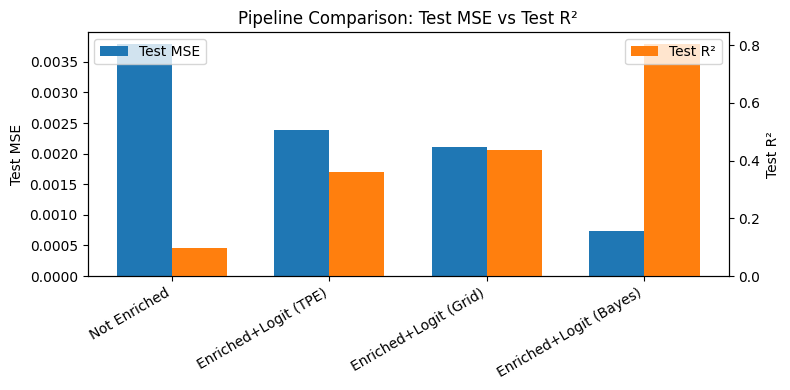

<ipython-input-41-b4e51260c69a>:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_mse.set_xticklabels(df["pipeline"], rotation=30, ha="right")
<ipython-input-41-b4e51260c69a>:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_r2.set_xticklabels(df["pipeline"], rotation=30, ha="right")


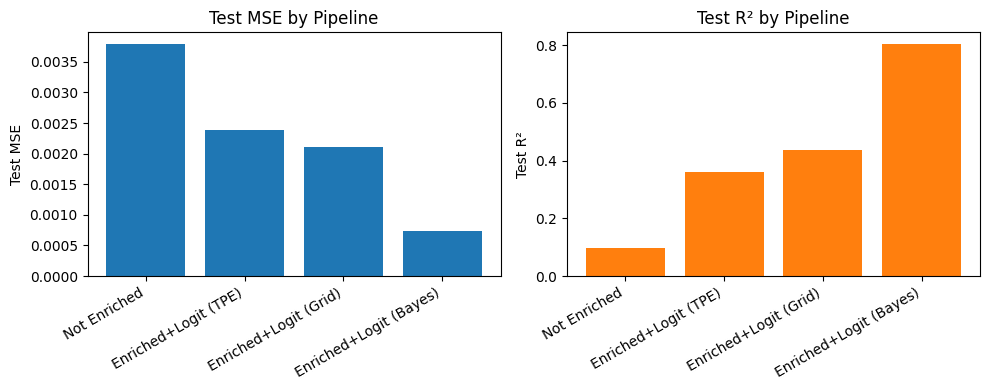

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1) Fill in your observed metrics here:
data = {
    "pipeline": [
        "Not Enriched",
        "Enriched+Logit (TPE)",
        "Enriched+Logit (Grid)",
        "Enriched+Logit (Bayes)"
    ],
    "Test MSE": [
        0.003793,  # from your baseline
        0.002391,  # TPE
        0.002109,  # replace with your GridTest MSE
        0.000733    # replace with your BayesTest MSE
    ],
    "Test R2": [
        0.096,     # baseline
        0.360,     # TPE
        0.435,   # replace with your GridTest R²
        0.804    # replace with your BayesTest R²
    ]
}

df = pd.DataFrame(data)

# 2) Plot side‑by‑side bar charts
x = np.arange(len(df))
width = 0.35

fig, ax1 = plt.subplots(figsize=(8,4))
bars1 = ax1.bar(x - width/2, df["Test MSE"], width, label="Test MSE")
ax1.set_ylabel("Test MSE")
ax1.set_xticks(x)
ax1.set_xticklabels(df["pipeline"], rotation=30, ha="right")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, df["Test R2"], width, label="Test R²", color="C1")
ax2.set_ylabel("Test R²")
ax2.legend(loc="upper right")

plt.title("Pipeline Comparison: Test MSE vs Test R²")
plt.tight_layout()
plt.show()

# 3) (Optional) Separate plots for clarity
fig, (ax_mse, ax_r2) = plt.subplots(1,2, figsize=(10,4))
ax_mse.bar(df["pipeline"], df["Test MSE"], color="C0")
ax_mse.set_title("Test MSE by Pipeline")
ax_mse.set_ylabel("Test MSE")
ax_mse.set_xticklabels(df["pipeline"], rotation=30, ha="right")

ax_r2.bar(df["pipeline"], df["Test R2"], color="C1")
ax_r2.set_title("Test R² by Pipeline")
ax_r2.set_ylabel("Test R²")
ax_r2.set_xticklabels(df["pipeline"], rotation=30, ha="right")

plt.tight_layout()
plt.show()
